<a href="https://colab.research.google.com/github/anushkamaisa/ML_LAB/blob/main/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


In [ ]:
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)
print("Dataset loaded successfully.")
print("Number of samples:", X.shape[0])
print("Number of features:", X.shape[1])


Dataset loaded successfully.
Number of samples: 569
Number of features: 30


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
baseline_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
baseline_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
y_pred_base = baseline_model.predict(X_test)
y_prob_base = baseline_model.predict_proba(X_test)[:,1]

In [ ]:
print("\n=== Baseline Model Performance ===")
print("Accuracy:", round(accuracy_score(y_test, y_pred_base), 4))
print("F1 Score:", round(f1_score(y_test, y_pred_base), 4))
print("ROC-AUC:", round(roc_auc_score(y_test, y_prob_base), 4))



=== Baseline Model Performance ===
Accuracy: 0.9561
F1 Score: 0.966
ROC-AUC: 0.9901


In [ ]:
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.001, 0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6, 8],
    'subsample': [0.6, 0.7, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.3, 0.5],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [0.5, 1, 2]
}



In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [ ]:
random_search = RandomizedSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_distributions=param_dist,
    n_iter=40, scoring='roc_auc', n_jobs=-1, cv=cv, verbose=1, random_state=42
)


In [ ]:
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_

Fitting 5 folds for each of 40 candidates, totalling 200 fits


In [ ]:
print("\nBest Parameters Found:")
print(random_search.best_params_)




Best Parameters Found:
{'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0.01, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}


In [ ]:
y_pred_tuned = best_model.predict(X_test)
y_prob_tuned = best_model.predict_proba(X_test)[:,1]

In [ ]:
print("\n=== Tuned Model Performance ===")
print("Accuracy:", round(accuracy_score(y_test, y_pred_tuned), 4))
print("F1 Score:", round(f1_score(y_test, y_pred_tuned), 4))
print("ROC-AUC:", round(roc_auc_score(y_test, y_prob_tuned), 4))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tuned))



=== Tuned Model Performance ===
Accuracy: 0.9649
F1 Score: 0.973
ROC-AUC: 0.9924

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        42
           1       0.95      1.00      0.97        72

    accuracy                           0.96       114
   macro avg       0.97      0.95      0.96       114
weighted avg       0.97      0.96      0.96       114



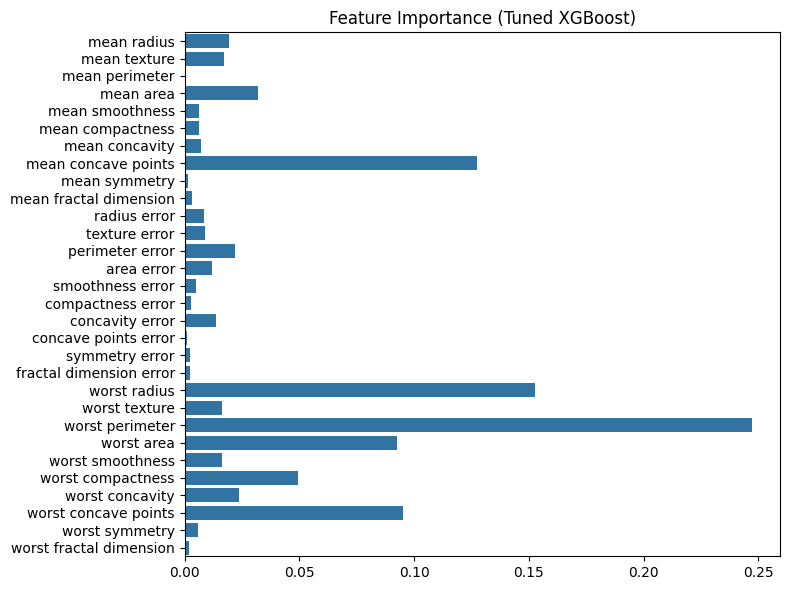

In [ ]:
plt.figure(figsize=(8,6))
sns.barplot(
    x=best_model.feature_importances_,
    y=data.feature_names,
    orient='h'
)
plt.title("Feature Importance (Tuned XGBoost)")
plt.tight_layout()
plt.show()
